In [9]:
%load_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots

import pandas as pd
import xarray as xr
import seaborn as sns
import warnings
import logging
# sns.set()

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## compute all densities per cs

In [10]:
### WINTER + SUMMER###
settings_paths = [
  # "settings/arpege_winter_30d.yaml", 
  # "settings/arpege_summer_30d.yaml", 

  # "settings/ifs_winter_30d.yaml" , 
  # "settings/ifs_summer_30d.yaml" , 
  
  # "settings/mpas_winter_30d.yaml", 
  # "settings/mpas_summer_30d.yaml", 

  # "settings/screamv1_winter_30d.yaml",
  # "settings/screamv1_summer_30d.yaml", 
 
  # "settings/sam_winter_30d.yaml", 
  # "settings/sam_summer_30d.yaml", 

  # "settings/um_winter_30d.yaml",
  # "settings/um_summer_30d.yaml",

  # "settings/xshield_winter_30d.yaml" , 
  # "settings/fv3_summer_30d.yaml", 
  
  # "settings/geos_winter_30d.yaml", 
  # "settings/grist_winter_30d.yaml", 
  # "settings/nicam_summer_30d.yaml", 

  "settings/obs_winter_30d.yaml", 
  # "settings/obs_summer_30d.yaml", 
               ]

nd = 4 
nbpd = 20

hdlrs = [handler.Handler(settings_path) for settings_path in settings_paths]
css = [casestudy.CaseStudy(hdlr, overwrite = False, verbose = False) for hdlr in hdlrs]
grs = [grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False) for cs in css]
jds = [joint_distrib.JointDistribution(gr, None, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_75_Prec", 
        nbpd = nbpd,  nd=nd, overwrite = True, dist_mask = False) for gr in grs]

Data loaded from /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_Winter_lowRes_Tropics/grid_attributes.pkl instead of computing


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


# fig 9 

In [11]:
from skimage import measure # pylance: disable=import-error 
from scipy.optimize import minimize
import plotly.graph_objects as go
from shapely.geometry import LineString
import matplotlib.patheffects as path_effects
from matplotlib.patches import Polygon as MplPolygon

def find_plot_contour(self, ax_show , N_branch=80, offset_low = 1, offset_up=1, color = 'k', lstyle = '--', model_name = None):
    Z = self.norm_density.T
    # -- Branches
    Z_contour = np.copy(Z)
    # Z_contour[18:, 18:] = 1 ## this number actually depends on nd and nbpd and the general shape of the Y 
    cont = measure.find_contours(Z_contour, 1)
    N = N_branch
    # fit
    popt_1, x_1, y_1, popt_2, x_2, y_2, func = self._fit_branches(cont,N, offset_low, offset_up)
    x_branch_2 = y_branch_1 = np.linspace(5,N_branch,N_branch)
    y_branch_2 = func(x_branch_2,*popt_2)
    x_branch_1 = func(y_branch_1,*popt_1)

    # Create line strings for intersection
    curve1 = LineString(np.column_stack((x_branch_1, y_branch_1)))
    curve2 = LineString(np.column_stack((x_branch_2, y_branch_2)))
    
    if ax_show is not False : 
        # show branches
        ax_show.plot(x_branch_1,y_branch_1, color = color, linestyle = lstyle, linewidth = 3, alpha = 0.5)
        ax_show.plot(x_branch_2,y_branch_2, color = color, linestyle = lstyle, linewidth = 3, alpha = 0.5, label  = model_name)

    return ax_show, curve1, curve2

def plot_kite(jd, fig=None, ax=None):
    if fig is None : 
        fig, ax = plt.subplots(1, 1)
    # Plot the initial polygons

    _, curve1, curve2 = find_plot_contour(jd, ax_show = False, N_branch=81, offset_low = 1, offset_up=1, color = 'k', lstyle="--", model_name = "None")

    curve1_coords = np.array(curve1.coords)

    km90_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,1]-20))
    last_index = np.argmin(np.abs(curve1_coords[:,1]-40))
    km90_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    km90_vertices.append((40, 40))  
    km90_vertices.append((20, 20))  

    km99_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,1]-40))
    last_index = np.argmin(np.abs(curve1_coords[:,1]-81))
    km99_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    km99_vertices.append((81, 81))  
    km99_vertices.append((40, 40))  

    curve1_coords = np.array(curve2.coords)

    dd90_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,0]-20))
    last_index = np.argmin(np.abs(curve1_coords[:,0]-40))
    dd90_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    dd90_vertices.append((40, 40))  
    dd90_vertices.append((20, 20))  

    dd99_vertices = []
    first_index = np.argmin(np.abs(curve1_coords[:,0]-40))
    last_index = np.argmin(np.abs(curve1_coords[:,0]-81))
    dd99_vertices.extend(curve1_coords[first_index:last_index+1])  # Add a segment of curve1

    dd99_vertices.append((81, 81))  
    dd99_vertices.append((40, 40))  

    polygons = [
        (km90_vertices, 'green', '90th \n km '),
        (km99_vertices, 'lime', '99th \n km '),
        (dd99_vertices, 'cyan', '99th \n dd '),
        (dd90_vertices, 'blue', '90th \n dd ')
    ]

    # Create a new patch with the constructed vertices
    for vertices, color, label in polygons:
                                                #reviewer doesn't like color so ciao facecolor=color
        polygon = MplPolygon(vertices, closed=True, edgecolor=color, facecolor="none", linewidth=3, linestyle='--', alpha=0.8) 
        ax.add_patch(polygon)
        
        # Calculate approximate center for text placement
        x_coords, y_coords = zip(*vertices)
        center_x = np.mean(x_coords) if "dd" in label else np.mean(x_coords)-8
        center_y = np.mean(y_coords) if "km" in label else np.mean(y_coords)-8
        
        # Add text annotation
        text = ax.text(center_x, center_y, label, color=color, fontsize=12, ha='center', va='center', weight='bold')
        text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='black'), path_effects.Normal()])
    
    return None

OBS_Winter_lowRes_Tropics


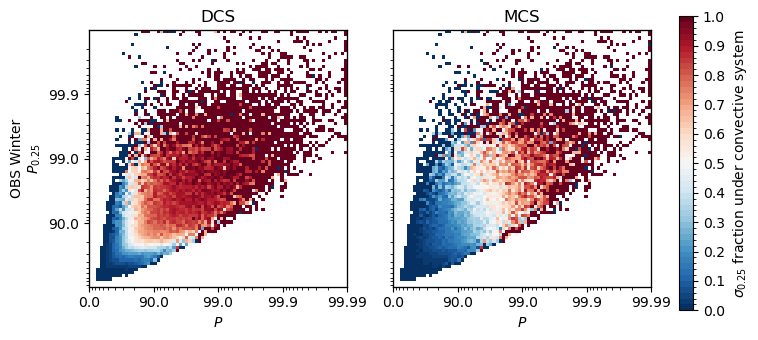

In [22]:
# jds_plot = [jds[-2], jds[-7]]

jds_plot = jds 

fig, axs  = plt.subplots(len(jds_plot), 2, figsize = (7, 3.5)) #, sharex=True, sharey=True)

letters = ["("+chr(97 + i)+")" for i in range(2*len(jds_plot))]  

plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.01, hspace=0.01)

cloud_cond_var_ids = ["vdcs_cond_prec_25", "mcs_cond_prec_25"] #"clouds_cond_prec_25",
titles = ["DCS", "MCS"]

cmap = plt.cm.RdBu_r
values_and_boundaries = np.arange(0, 1.02, 0.02)
values = values_and_boundaries[::5]
boundaries  = values_and_boundaries
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

for i, jd, gr, axes in zip(range(len(jds_plot)), jds_plot, grs, [axs]):
    print(jd.name)
    for j, cloud_cond_var_id, ax, title in zip(range(len(axes)), cloud_cond_var_ids, axes, titles):
        
        # letter = letters[2*i+j]
        # ax.text(0.01, 0.94, letter,  transform=ax.transAxes, fontweight='bold')
        
        ax, cbar, ax_show, density = jd.plot_var_id_func_over_jdist(cloud_cond_var_id, title=title,  func = 'intersection_over_half_intersection', mask = 'all', cmap = cmap, norm = norm, fig = fig, ax = ax)
        cbar.remove()

        # plot_smoothed_density_contours(density, [0.2, 0.8], fig, ax_show)            
        # ax.set_title(r"$\rho_{0.5} $ for joint bins of $(P; P_{0.5})$")
        if i != 0 : 
            ax.set_title("")

        if j == 0:
            ax.set_ylabel(jd.name.split("_")[0] + " " + jd.name.split("_")[1] + "\n" +r"$P_{0.25}$")
        else:
            ax.set_ylabel("")
            ax.tick_params(left=False, labelleft=False)
        if i == len(jds_plot) - 1:
            ax.set_xlabel(r"$P$")
        else:
            ax.set_xlabel("")
            ax.tick_params(bottom=False, labelbottom=False)

        # if j==0 : 
        #     plot_kite(jd, fig, ax_show)

plt.tight_layout()
cax = fig.add_axes([0.99, 0.099, 0.02, 0.84])  # [left, bottom, width, height]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=values, spacing='proportional')
cbar.set_label(r'$\sigma_{0.25}$ fraction under convective system')

plt.savefig("final_fig/fig9.pdf", bbox_inches = "tight", pad_inches=0.1)

# Fig 10

In [6]:
cloud_cond_var_ids = ["vdcs_cond_prec_25", "mcs_cond_prec_25"]

results = np.zeros((len(cloud_cond_var_ids), 4, len(jds)))

jdist_shape = (nd*nbpd+1, nd*nbpd+1)

for i, jd, gr in zip(range(len(jds)), jds, grs):
    jd.make_mask()
    mask_dd = jd.mask_coloc_ac_90
    mask_km = jd.mask_coloc_c_90

    mask_dd_90th = mask_dd.copy()
    mask_dd_90th[20:40, 20:40] = False

    mask_dd_99th = mask_dd.copy()
    mask_dd_99th[40:, 40:] = False

    mask_km_90th = mask_km.copy()
    mask_km_90th[20:40, 20:40] = False

    mask_km_99th = mask_km.copy()
    mask_km_99th[40:, 40:] = False
    for j, cloud_cond_var_id in enumerate(cloud_cond_var_ids):
        print(jd.name)
        ax, cbar, ax_show, density = jd.plot_var_id_func_over_jdist(cloud_cond_var_id, title="None",  func = 'intersection_over_half_intersection', mask = 'all', fig = False)
        bincount = (jd.bincount.T * density.T)
        results[j,0,i] = np.nansum(bincount[mask_km_90th])/np.nansum(jd.bincount.T[mask_km_90th])
        results[j,1,i] = np.nansum(bincount[mask_km_99th])/np.nansum(jd.bincount.T[mask_km_99th])
        results[j,2,i] = np.nansum(bincount[mask_dd_90th])/np.nansum(jd.bincount.T[mask_dd_90th])
        results[j,3,i] = np.nansum(bincount[mask_dd_99th])/np.nansum(jd.bincount.T[mask_dd_99th])
    
        # print(cloud_cond_var_id, "dd", (np.nansum(bincount[mask_dd_90th])+np.nansum(bincount[mask_dd_99th]))/(np.nansum(jd.bincount.T[mask_dd_99th])+np.nansum(jd.bincount.T[mask_dd_90th])))
        # print(cloud_cond_var_id, "km", (np.nansum(bincount[mask_km_90th])+np.nansum(bincount[mask_km_99th]))/(np.nansum(jd.bincount.T[mask_km_99th])+np.nansum(jd.bincount.T[mask_km_90th])))
    
        print(cloud_cond_var_id, "99th dd", (np.nansum(bincount[mask_dd_99th]))/(np.nansum(jd.bincount.T[mask_dd_99th])))
        print(cloud_cond_var_id, "99th km", (np.nansum(bincount[mask_km_99th]))/(np.nansum(jd.bincount.T[mask_km_99th])))
    
# plt.close()

ARPEGE_Winter_lowRes_Tropics
vdcs_cond_prec_25 99th dd 0.7499499659768643
vdcs_cond_prec_25 99th km 0.7367210500490677
ARPEGE_Winter_lowRes_Tropics
mcs_cond_prec_25 99th dd 0.2419245086658928
mcs_cond_prec_25 99th km 0.24288518155053976
ARPEGE_Summer_lowRes_Tropics
vdcs_cond_prec_25 99th dd 0.11824136262861566
vdcs_cond_prec_25 99th km 0.20910227173345558
ARPEGE_Summer_lowRes_Tropics
mcs_cond_prec_25 99th dd 0.0077300304760868
mcs_cond_prec_25 99th km 0.03565285835058158
IFS_Winter_lowRes_Tropics
vdcs_cond_prec_25 99th dd 0.5832855939342881
vdcs_cond_prec_25 99th km 0.728866587957497
IFS_Winter_lowRes_Tropics
mcs_cond_prec_25 99th dd 0.18207245155855098
mcs_cond_prec_25 99th km 0.37801062573789845
IFS_Summer_lowRes_Tropics
vdcs_cond_prec_25 99th dd 0.46608743432123356
vdcs_cond_prec_25 99th km 0.7106855136187918
IFS_Summer_lowRes_Tropics
mcs_cond_prec_25 99th dd 0.1526151310141145
mcs_cond_prec_25 99th km 0.3550033936317762
MPAS_Winter_lowRes_Tropics
vdcs_cond_prec_25 99th dd 0.8324457

In [7]:
num_colors = 10
cmap = plt.get_cmap('hsv')
color_values = np.linspace(0, 0.9, num_colors)
model_colors = [cmap(value) for value in color_values]
model_colors[2] = (1.0, 1.0, 0.0, 1.0) ## yellow
model_colors[3] = (0.6, 1.0, 0.0, 1.0) ## greenish yellow

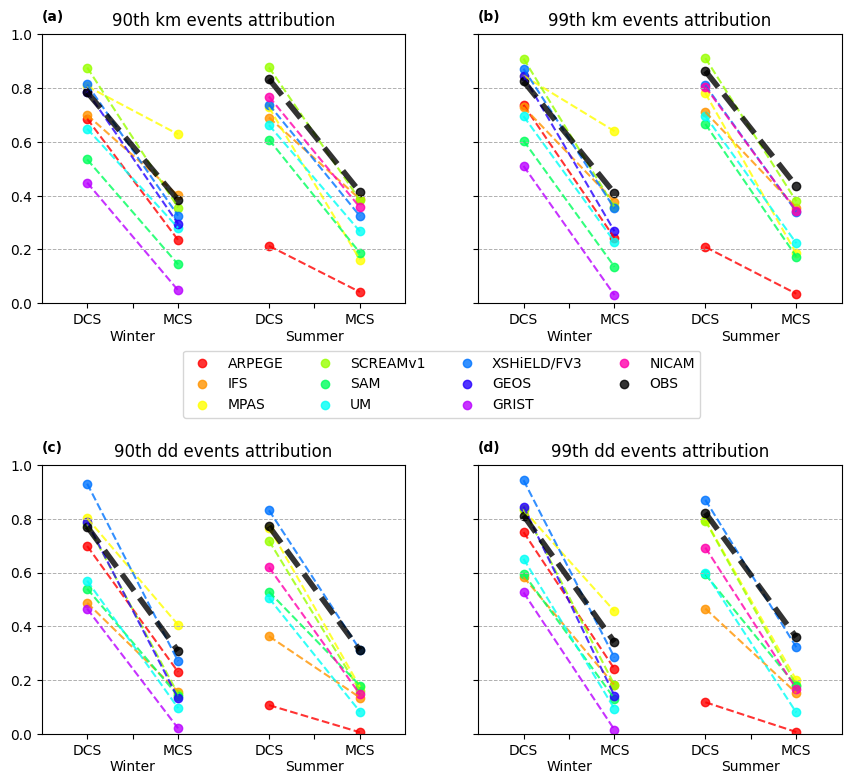

In [8]:
titles = ["90th km", "99th km", "90th dd", "99th dd"]
letters = ["("+chr(97 + i)+")" for i in range(4)]  # (a), (b), (c), (d)

# Prepare figure with 4 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,7), sharey=True)

# A dictionary to collect model handles for a single (merged) legend
model_handles = {}

for i in range(4):
    ax = axes[i//2, i%2]
    ax.set_title(titles[i] + " events attribution")
    ax.text(0, 1.05, letters[i], transform=ax.transAxes, fontweight='bold')

    # For each j, plot the results into the same axis
    for j, jd in enumerate(jds):
        model_name, season = jd.name.split("_")[0], jd.name.split("_")[1]
        
        # Pick color based on model_name (adjust as desired)
        if model_name == "NICAM":  
            color = model_colors[9]
        elif model_name == "OBS":
            color = "black"
        elif model_name == "GRIST":
            color = model_colors[8]
        elif model_name == "FV3" or model_name == "XSHiELD":
            color = model_colors[6]
            model_name = "XSHiELD/FV3"
        else:
            color = model_colors[j // 2]  # or however you choose colors

        # Decide x offsets for Winter vs Summer
        if season == "Winter":
            x_offset = 0  # left pair: x=0 for DCS, x=1 for MCS
        else:
            x_offset = 2  # right pair: x=2 for DCS, x=3 for MCS

        # Go through the cloud types (DCS=0, MCS=1), place them side by side
        for c, cloud_type in enumerate(cloud_cond_var_ids):
            x_val = x_offset + c
            y_val = results[c, i, j]

            # For the very first point (cloud_type=0), add model_name to legend
            # so each model only appears once in the final legend
            if (model_name not in model_handles) and (c == 0):
                scat = ax.scatter(x_val, y_val, color=color, alpha=0.8,
                                  label=model_name)
                # Collect the handle only once per model
                model_handles[model_name] = scat
            else:
                ax.scatter(x_val, y_val, color=color, alpha=0.8)

            # Optionally connect DCS->MCS with a line if you want them connected
            # only when c == 0
            if c == 0:
                x_next = x_offset + c + 1
                y_next = results[c+1, i, j]  # MCS
                # Different style for "OBS"
                if color == "black":
                    ax.plot([x_val, x_next], [y_val, y_next],
                            color=color, linestyle="--", linewidth=4, alpha=0.8)
                else:
                    ax.plot([x_val, x_next], [y_val, y_next],
                            color=color, linestyle="--", alpha=0.8)

    # Cosmetics for each row
    ax.set_ylim(0, 1)
    ax.set_xlim(-0.5, 3.5)
    # Show x-ticks for 4 positions: 0->DCS(Winter), 1->MCS(Winter), 
    #                               2->DCS(Summer), 3->MCS(Summer).
    ax.set_xticks([0, 0.5, 1, 2, 2.5, 3])
    ax.set_xticklabels(["DCS", "\nWinter","MCS",
                        "DCS", "\nSummer", "MCS"])
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

fig.legend(
    handles=model_handles.values(),
    labels=model_handles.keys(),
    loc="center",
    ncol=4,  
    bbox_to_anchor=(0.5, 0.5)  # (x, y) in figure coordinates
)

# plt.tight_layout()  # or adjust rect if needed
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0.6)
plt.savefig("final_fig/fig10.pdf", bbox_inches = "tight", pad_inches=0.1)
plt.show()